In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

## Data Preparation

In [59]:
stock_list = ['NVDA', 'TSLA','AMD', 'GOOG']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [60]:
for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

df_nvidia = globals()['NVDA']
df_amd = globals()['AMD']
df_tsla = globals()['TSLA']
df_goog = globals()['GOOG']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [61]:
window_size = 60

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

### 4/29 - 5/4 Stock Purchases and Reasoning:

I chose the stocks: Nvidia, Tesla, AMD, and Google as my investments. Below is my reasoning and analysis for each stock.

### Nvidia

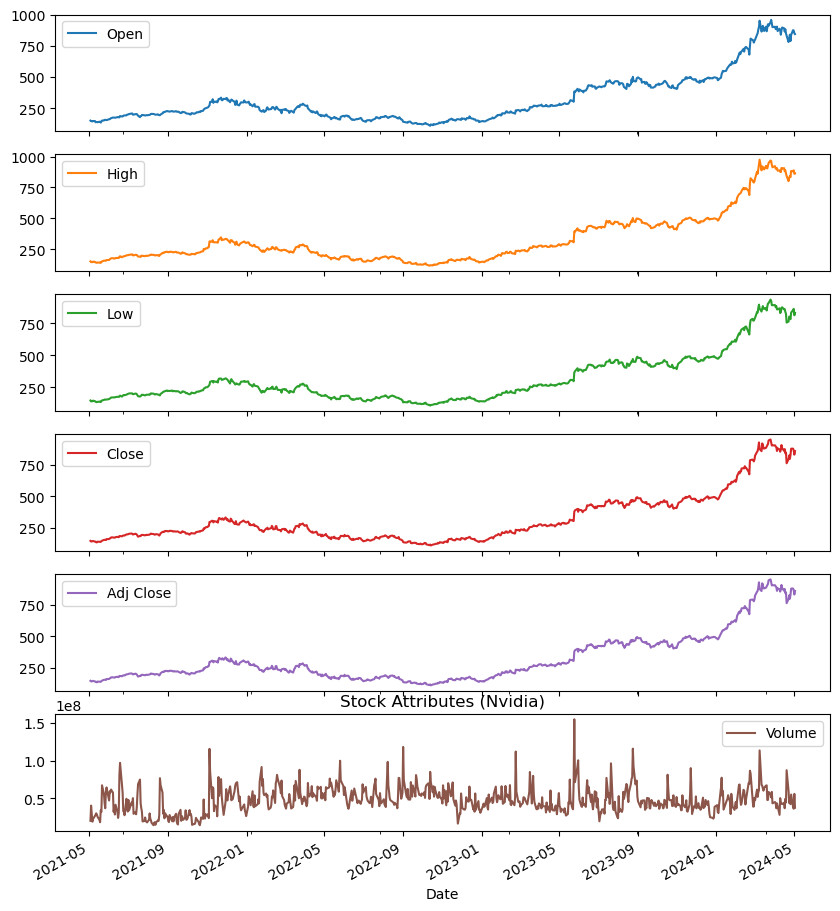

In [62]:
df_nvidia.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

It can be seen that the trends between all data points aside volume are largely the same. Little dilation from each other, this could mean that Nvidia has been on a steady rise throughout Covid but had a massive spike near 2024.

In [63]:
fig = px.line(df_nvidia, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

There was a spike in November 2021 that lines up with the rise of AI and ChatGPT. With GPUs being a major asset to running and processing AI. 

Judging from the chart, January 2022 to September 2022 was Nvidia's 52 week low after the US imposed restrictions on the export of AI chips to China and Russia. The 239% rise in 2023 would be due to the fervor over generative AI reaching a peak height. Nvidia skyrocketed again in 2024 over further AI demand. There are high chances that Nvidia may reach the $1000 stock price soon if it continues to rise. Right now residing between $900 to $800 per stock.

In [64]:
fig = px.line(df_nvidia, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

We see one noticeable spikes in trades in May 2023. In 2024, the high cost in the stock may be the reason as to why it is so low in trade volume.

In [65]:
# Nvidia Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_nvidia.index, open=df_nvidia['Open'], high=df_nvidia['High'], low=df_nvidia['Low'], close=df_nvidia['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

Judging from the Candstick chart, stock prices had a high rise near the start of 2024 but began to make a noticeable decline in April 2024, this can be related to the AMD earnings report that caused a decline in stock for a period. 

Text(0.5, 1.0, 'Nvidia Moving Averages')

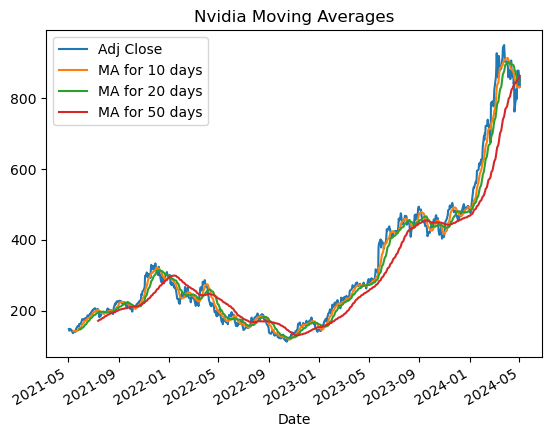

In [66]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_nvidia[column_name] = df_nvidia['Adj Close'].rolling(ma).mean()

df_nvidia[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Nvidia Moving Averages")

Based on the Moving Average Graph above, it can be seen that the moving average for 10 and 20 days is signaling a trend shift that connects with AMD's recent conference with investors that led to a drop in stocks by 3% for NVIDIA. 

Following the 50 day moving average, we can see that the data is doing better than the expected average aside from the sudden drop and recovery of the stock price.

Text(0.5, 1.0, 'Nvidia Daily Return')

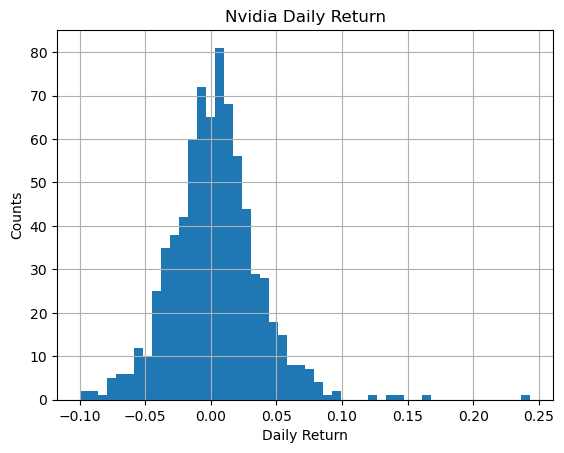

In [67]:
df_nvidia['Daily Return'] = df_nvidia['Adj Close'].pct_change()
df_nvidia['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Nvidia Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis. Increasing and decreasing approximately 5%. But overall the daily return forms a unimodal distribution.

#### Prediction Model For Nvidia

In [68]:
start = datetime(end.year - 5, end.month, end.day)
df_nvidia = pdr.get_data_yahoo('NVDA', start=start, end=end)

X = df_nvidia[['High', 'Low', 'Open']]  # Features
y = df_nvidia['Close']  # Target variable

data = df_nvidia.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

# data set for within 60 days
test_data = scaled_data[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

[*********************100%%**********************]  1 of 1 completed

Epoch 1/100


30/30 [==============================] - 2s 23ms/step - loss: 0.0251 - val_loss: 0.0022
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 8.6528e-04
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 6.9952e-04 - val_loss: 4.2532e-04
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 5.0075e-04 - val_loss: 4.2385e-04
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 4.5495e-04 - val_loss: 3.4988e-04
Epoch 6/100
30/30 [==============================] - 1s 18ms/step - loss: 4.0405e-04 - val_loss: 3.0914e-04
Epoch 7/100
30/30 [==============================] - 1s 18ms/step - loss: 3.8209e-04 - val_loss: 2.8939e-04
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 3.6128e-04 - val_loss: 2.7329e-04
Epoch 9/100
30/30 [==============================] - 1s 17ms/step - loss: 3.4236e-04 - val_loss: 2.5554e-04
Epoch 10/100
30/30 [==============================] 

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

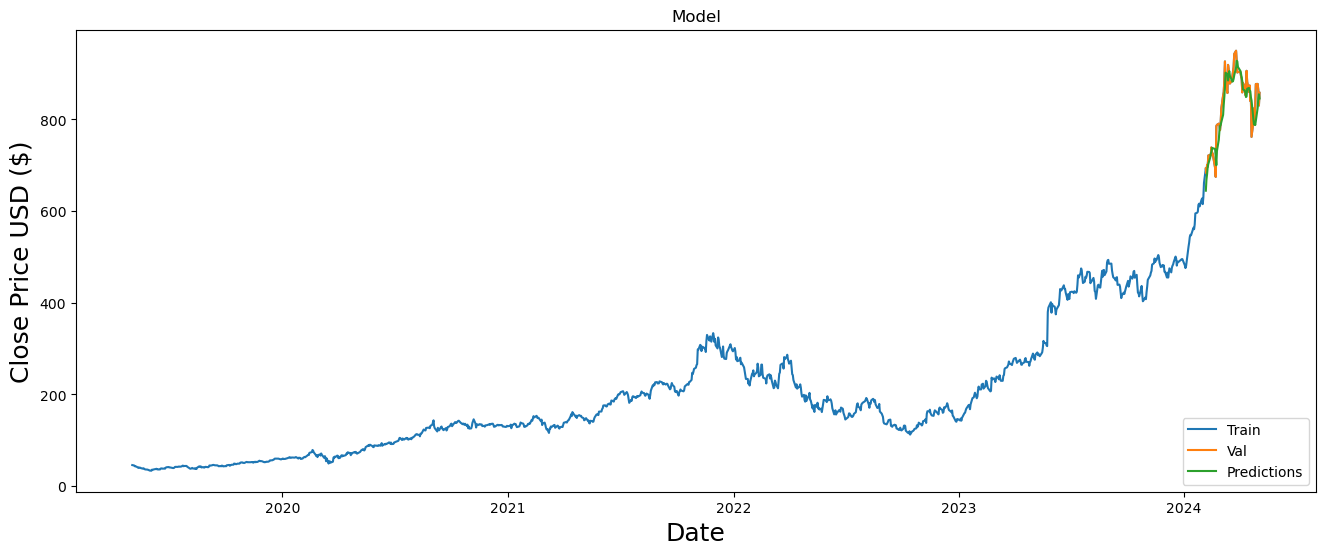

In [69]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_nvidia['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [70]:
valid

,Close,Predictions
Date,,
2024-02-05,693.320007,644.519043
2024-02-06,682.229980,668.372009
2024-02-07,700.989990,680.443604
2024-02-08,696.409973,695.549561
2024-02-09,721.330017,702.803528
...,...,...
2024-04-26,877.349976,797.125549
2024-04-29,877.570007,825.549622
2024-04-30,864.020020,846.104248


#### Prediction

In [71]:
future_days = 5

last_60_days = scaled_data[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    predicted_values.append(predicted_decimal[0][0])
    
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value
    
print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 17ms/step
Predicted Decimal Values for the Next 5 Days: [850.6308, 849.9376, 848.6503, 846.8075, 844.4876]


#### Conclusion

Under my analysis, Nvidia would be ideal as a long-term investment. With its boom coming from the AI boom in late 2021. It has had moments of reaching lows such as in 2022 by outside factors such as the government. But early 2024 has seen the company have a large boom in its stock price, soaring to reach more than $900 dollars a few points in time in 2024. 

It may be an opportune time due to an uninspiring announcement by AMD that had also affected Nvidia too in 5/1/24, causing the stock to have a sudden drop however there is a high chance for it to continue to outperform for the rest of 2024. Predictions from the LSTM model show the stock prices already recovering. 

The stock prices will continue to rise over the demand of AI over time as Nvidia still stands in market as the forefront of the AI chip race. It seems that Nvidia will continue to rise while other companies are attempting to catch up.

### AMD

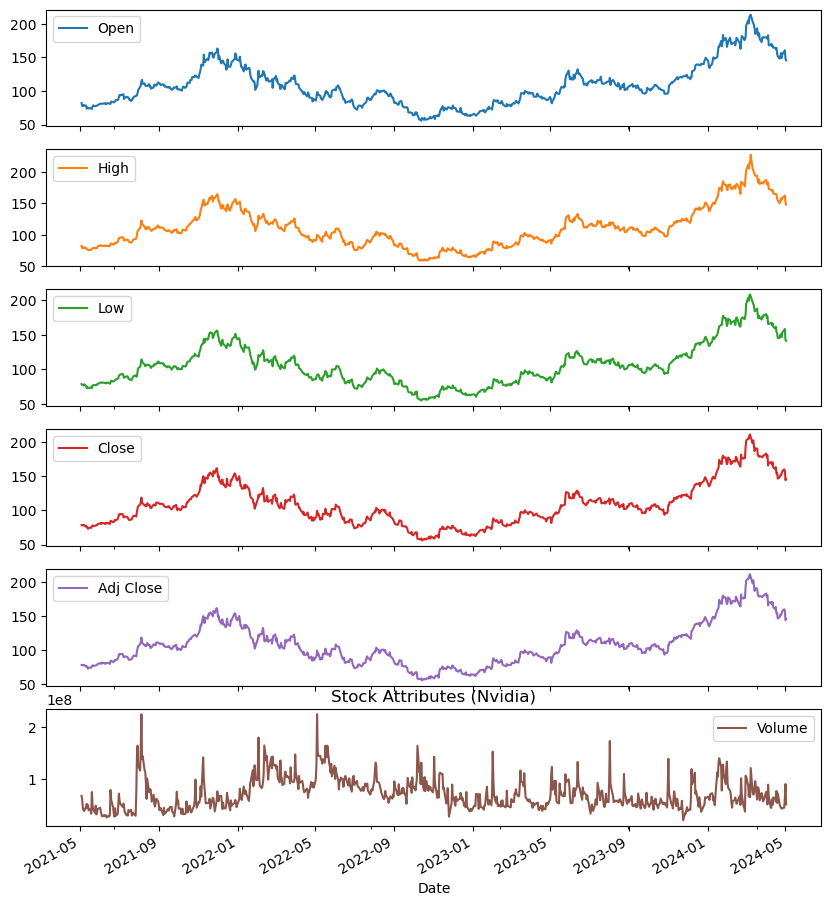

In [72]:
df_amd.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [73]:
fig = px.line(df_amd, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Judging the Closing price, AMD has been experiencing volatile rise and drop in its price.

AMD in October 2022 reached its lowest stock price on the chart due reporting a 40% decline in its client segment (PCs) that was almost the entire reason for AMD's shortfall when the PC makert came to a standstill in the second half of summer in 2022.

AMD in March 2024 experienced a high rise in stock price due to their announcement of their MI300 series AI chip for HPC and generative AI. Leading many investors heavily invest into the stock over the AI craze. But such rapid growth may be unsustainable due to the stronger position their competitors may have such as Nvidia and if the company fails to meet expectations may lead to significant damage to the stock.

The most recent drop can be explained with AMD's struggle to impress Wall Street with its earnings season, investors were not impressed even amid the rise in AI demand. Leading to a near 9% drop in stock price and affecting other company stocks such as Nvidia with a 3% stock drop. 

In [74]:
fig = px.line(df_amd, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [75]:
# AMD Candlestick Chart
# Further detailed chart evaluating noticeable drops and rises in data.

fig = go.Figure(data=[go.Candlestick(x=df_amd.index, open=df_amd['Open'], high=df_amd['High'], low=df_amd['Low'], close=df_amd['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

Starting March 2024, we can begin to see a downward slope begin to form following AMD reaching its peak in Stock Price. The drop in stock price could be attributed to AMD Stock price reaching $200 leading to some stock investors to begin to sell their stock.

Text(0.5, 1.0, 'AMD Moving Averages')

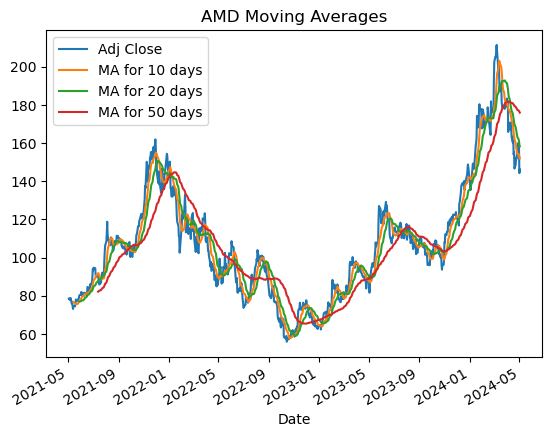

In [76]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()

df_amd[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("AMD Moving Averages")

Based on the graph, the moving average for 10 and 20 days are following the trend on a downward line and having moments where the stock experiences worse than the expected average. Signaling us that the stock is beginning a negative slope after recent news regarding their earnings report and would be best to hold off selling if plans for the stock were short-term. The drop in stock price is worse than the expected moving average for 50 days, showing that it be a good time to invest into AMD before it can recover in the future.

Text(0.5, 1.0, 'AMD Daily Return')

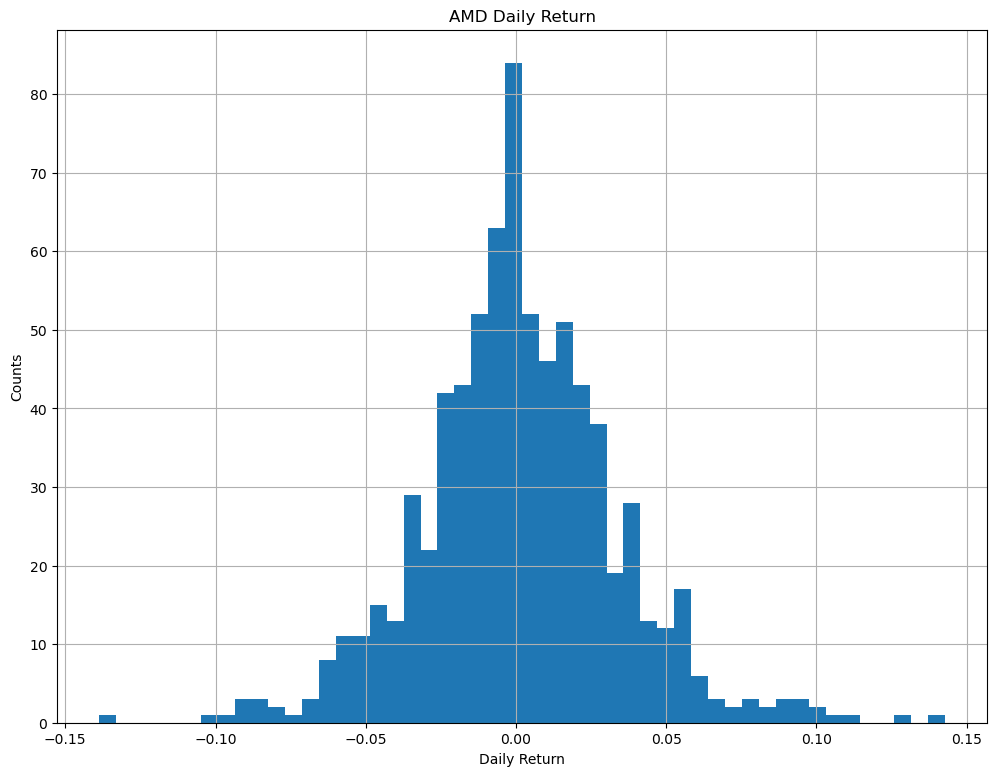

In [77]:
df_amd['Daily Return'] = df_amd['Adj Close'].pct_change()
plt.figure(figsize=(12,9))

df_amd['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('AMD Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis. Increasing and decreasing approximately 5%, forming a unimodal distribution.

#### Prediction Model For AMD

In [78]:
start = datetime(end.year - 5, end.month, end.day)
df_amd = pdr.get_data_yahoo('AMD', start=start, end=end)

X = df_amd[['High', 'Low', 'Open']]  # Features
y = df_amd['Close']  # Target variable

data = df_amd.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

# data set for within 60 days
test_data = scaled_data[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

[*********************100%%**********************]  1 of 1 completed

Epoch 1/100
 9/30 [========>.....................] - ETA: 0s - loss: 4.9264e-04

30/30 [==============================] - 1s 17ms/step - loss: 4.8199e-04 - val_loss: 4.7930e-04
Epoch 2/100
30/30 [==============================] - 0s 17ms/step - loss: 4.6320e-04 - val_loss: 3.2399e-04
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 4.4510e-04 - val_loss: 3.9561e-04
Epoch 4/100
30/30 [==============================] - 0s 16ms/step - loss: 4.4766e-04 - val_loss: 3.1773e-04
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 4.7374e-04 - val_loss: 3.0634e-04
Epoch 6/100
30/30 [==============================] - 1s 18ms/step - loss: 4.2076e-04 - val_loss: 3.0797e-04
Epoch 7/100
30/30 [==============================] - 0s 17ms/step - loss: 4.3369e-04 - val_loss: 3.1237e-04
Epoch 8/100
30/30 [==============================] - 0s 17ms/step - loss: 4.2416e-04 - val_loss: 3.0814e-04
Epoch 9/100
30/30 [==============================] - 1s 17ms/step - loss: 4.1232e-04 - val_loss: 3.0799e-04
Epoch 10/100
30/30 [====================

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

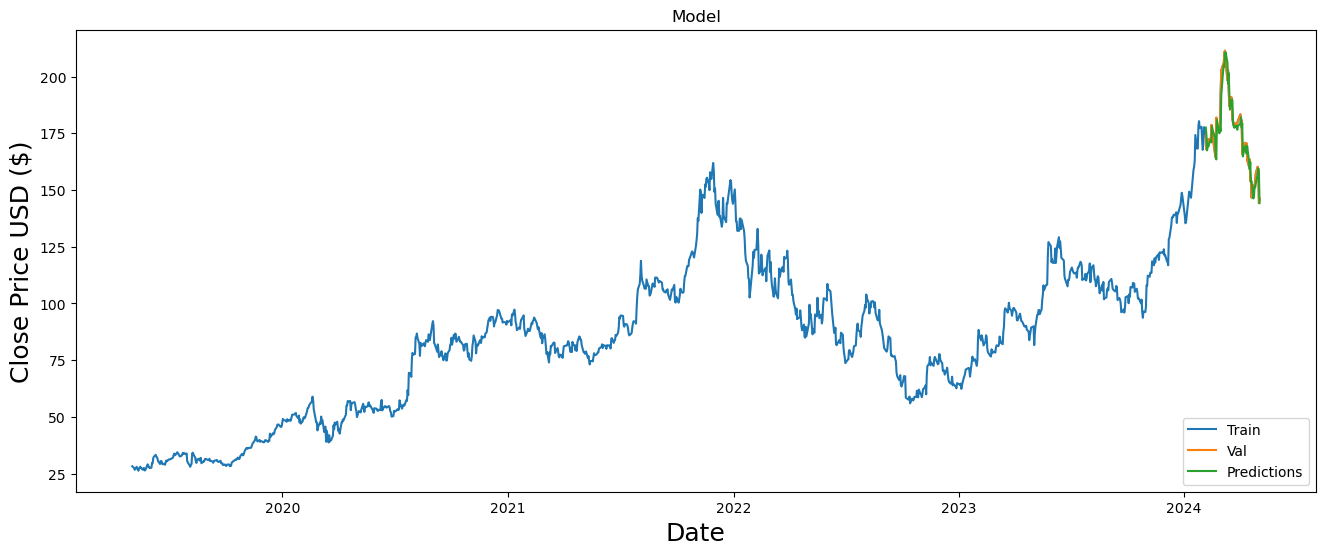

In [79]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [80]:
valid

,Close,Predictions
Date,,
2024-02-05,174.229996,177.497681
2024-02-06,167.880005,174.146637
2024-02-07,170.940002,167.449020
2024-02-08,169.350006,170.373398
2024-02-09,172.479996,169.090530
...,...,...
2024-04-26,157.399994,152.956192
2024-04-29,160.199997,156.617645
2024-04-30,158.380005,159.504028


#### Prediction

In [81]:
future_days = 5

last_60_days = scaled_data[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    predicted_values.append(predicted_decimal[0][0])
    
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value
    
print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 18ms/step
Predicted Decimal Values for the Next 5 Days: [145.19601, 144.85332, 144.45192, 144.07211, 143.7175]


#### Conclusion

From my results, there is reason to invest into AMD as a long-term investment. AMD's stock is facing a downward trend with its recent AI chip sales for 2024 falling short of expectations by Wall Street Investors compared to Nvidia beating its expectations.

Predictions from the model show the stock follow a downward trend for the next days following its drop in stock on May 1st. While it continues to drop, it will be an opportune time to invest into AMD's stock.

The AI trend will likely continue thanks to rapid development of AI which will fuel demand for semiconductor products. There is a high chance for AMD to rebound due to AI demand.

### Tesla

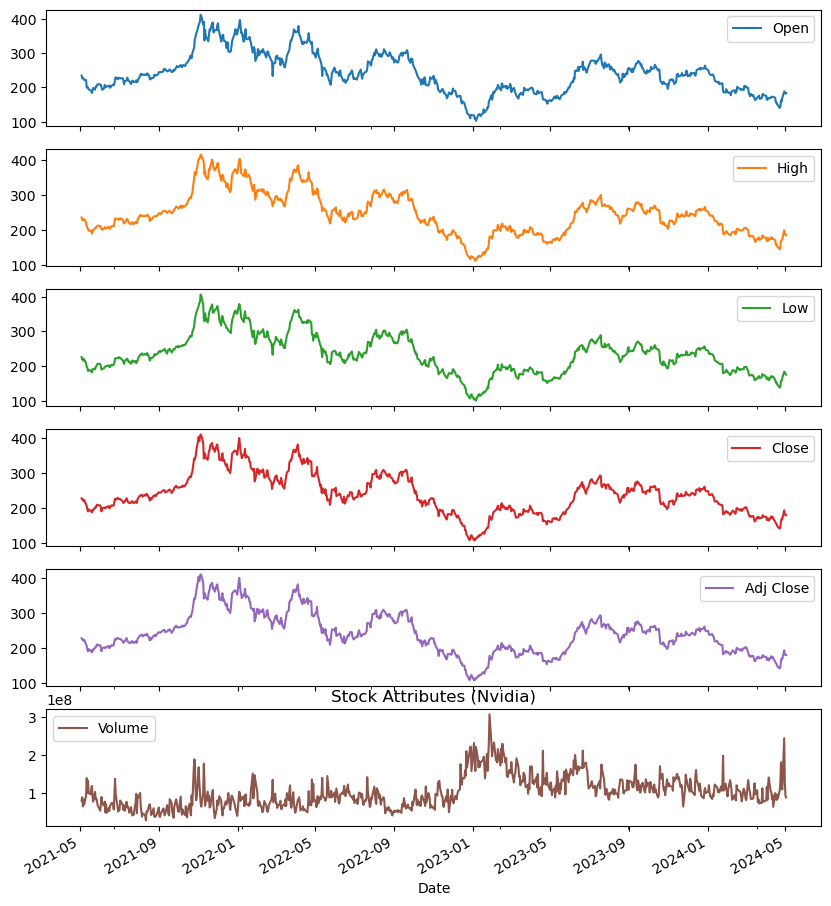

In [82]:
df_tsla.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [83]:
fig = px.line(df_tsla, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Looking at the stock data, it can seen that Tesla is a very volatile stock market. Having many rises and falls in the past few years. 

In 2022, stock dropped significantly before January 2023 due to the announcement by Tesla of their delivery numbers being down, causing a significant drop in stock price. Being their first year-over-year sales drop since the early days of Covid in 2020.

In May 2023, despite its volatility, Tesla's stock doubled investor's money as it surged 101.7%. It is said that Tesla deliveries surged 38% with its lower priced models attributed for 98% of the surge in orders. Allowing for Tesla to meet two important targets which were delivering 1.8 million cars and starting production of the Cybertruck. With them meeting their goals and strong demand it drove Tesla's stock higher.

In April 2024, Tesla had a significant after it was revealed that the company's Autopilot feature had hit and killed a motorcyclist as well as a recall for Cybertrucks, leading to a drop in stock price.

In [84]:
fig = px.line(df_tsla, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [85]:
# Tesla Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_tsla.index, open=df_tsla['Open'], high=df_tsla['High'], low=df_tsla['Low'], close=df_tsla['Close'])])

fig.update_layout(title='Tesla Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

Text(0.5, 1.0, 'Tesla Moving Averages')

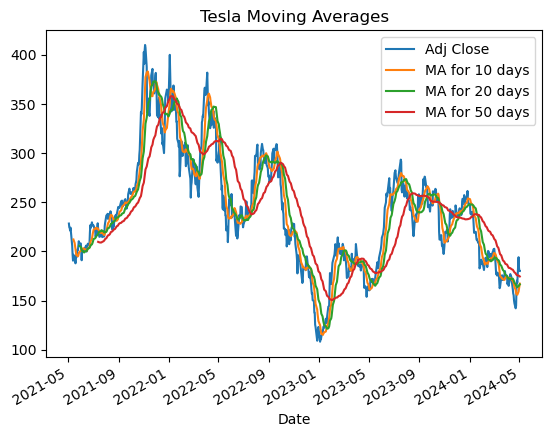

In [86]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_tsla[column_name] = df_tsla['Adj Close'].rolling(ma).mean()

df_tsla[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Tesla Moving Averages")

Following the Moving Average Chart, The moving average for 10 and 20 days is following the trend closely and beginning to show a turning point in recovery. The moving average for 50 days shows that the stock is doing worse than the moving average due to the volatility of the stock. Investing into the stock as it is experiencing worse than the 50 day moving average is a good option. Tesla has been experiencing good long term growth, due to its volatility it is not good for short-term investment.

Text(0.5, 1.0, 'Tesla Daily Return')

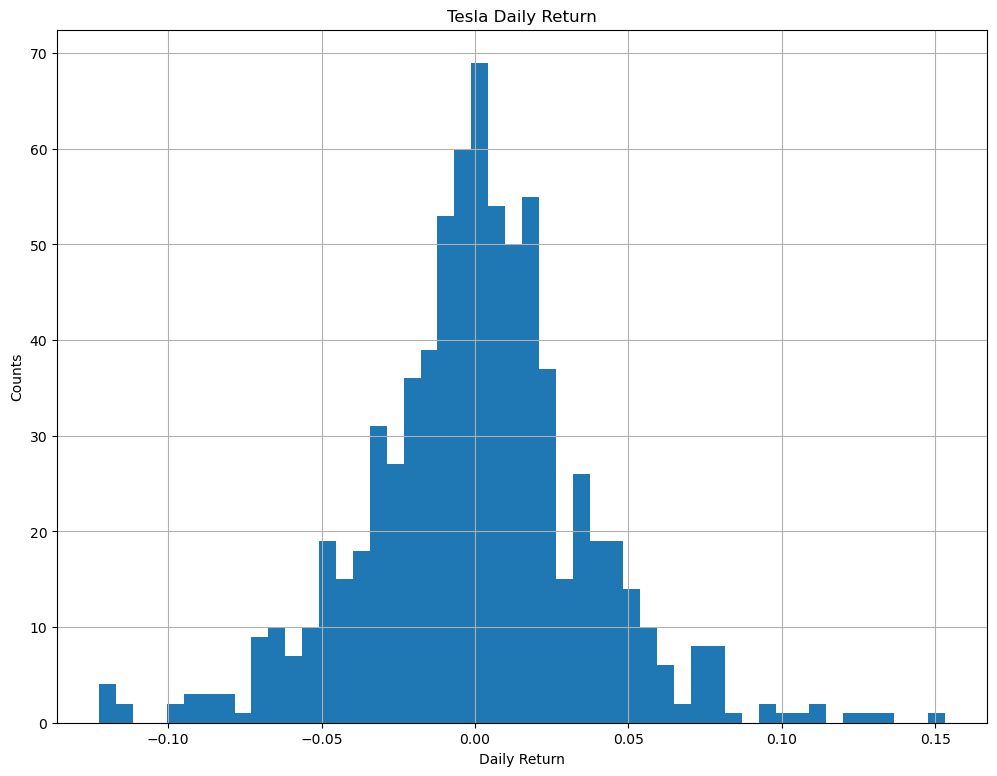

In [87]:
df_tsla['Daily Return'] = df_tsla['Adj Close'].pct_change()

plt.figure(figsize=(12,9))

df_tsla['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Tesla Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis, forming a unimodal distribution. Increasing and decreasing approximately 5% but there is a noticeable percentage of change ocurring between -10% and -5%.

#### Prediction Model for Tesla

In [88]:
start = datetime(end.year - 5, end.month, end.day)
df_tsla = pdr.get_data_yahoo('TSLA', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [89]:
X = df_tsla[['High', 'Low', 'Open']]  # Features
y = df_tsla['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_tsla.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

# creating a new dataset to analyze within 60 days
test_data = scaled_prices[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 4.4476e-04 - val_loss: 4.2984e-04
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 4.1361e-04 - val_loss: 4.3527e-04
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 3.9927e-04 - val_loss: 4.4358e-04
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 4.2067e-04 - val_loss: 4.3244e-04
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 4.1018e-04 - val_loss: 4.2948e-04
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 4.0677e-04 - val_loss: 4.4169e-04
Epoch 7/100
30/30 [==============================] - 0s 16ms/step - loss: 4.1934e-04 - val_loss: 4.9987e-04
Epoch 8/100
30/30 [==============================] - 0s 15ms/step - loss: 4.1871e-04 - val_loss: 4.8252e-04
Epoch 9/100
30/30 [==============================] - 0s 15ms/step - loss: 4.4736e-04 - val_loss: 4.6366e-04
Epoch 10/100
30/30 [========

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

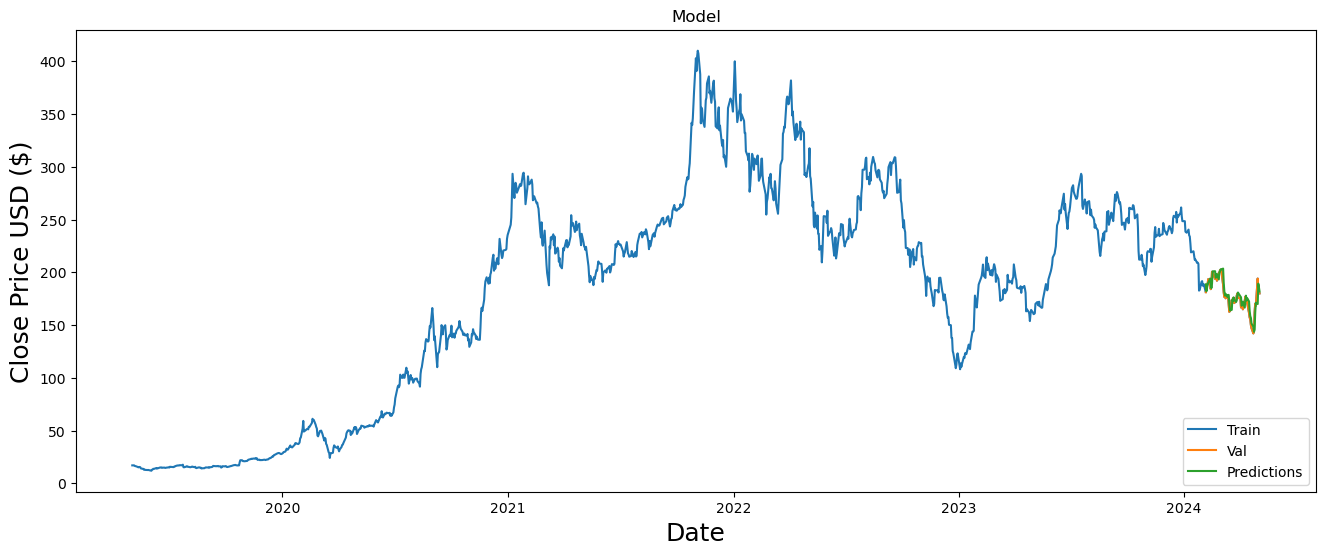

In [90]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_tsla['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [91]:
valid

,Close,Predictions
Date,,
2024-02-05,181.059998,188.612762
2024-02-06,185.100006,182.048340
2024-02-07,187.580002,185.532486
2024-02-08,189.559998,188.275055
2024-02-09,193.570007,190.229874
...,...,...
2024-04-26,168.289993,171.141281
2024-04-29,194.050003,169.901779
2024-04-30,183.279999,189.204254


#### Prediction

In [92]:
future_days = 5

last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    # Predict the next day
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    # Store the predicted value
    predicted_values.append(predicted_decimal[0][0])
    
    # Shift the input data by one day for the next prediction
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value  # Replace the last value with the predicted value

print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 17ms/step
Predicted Decimal Values for the Next 5 Days: [181.3994, 182.6487, 183.85223, 184.99745, 186.10606]


#### Conclusion

From my results, investing into Tesla stock is a good future long-term investment. Due to its high volatility, the stock is too unstable for a short-term investment. With recent stories regarding Tesla's AI and recall, it may prove a good time to invest while the stock tries to recover. Especially with Tesla's most recent earnings report resulted in an increase in stock price by 20%. 

For now, predictions show that the stock will continue to rise in the coming days. Especially with the impact of other companies and their announcements that led to a subsequent rise in stock price for a number of tech companies. It would be best to begin to ride Tesla's trend line as it begins to rise again.

### Google

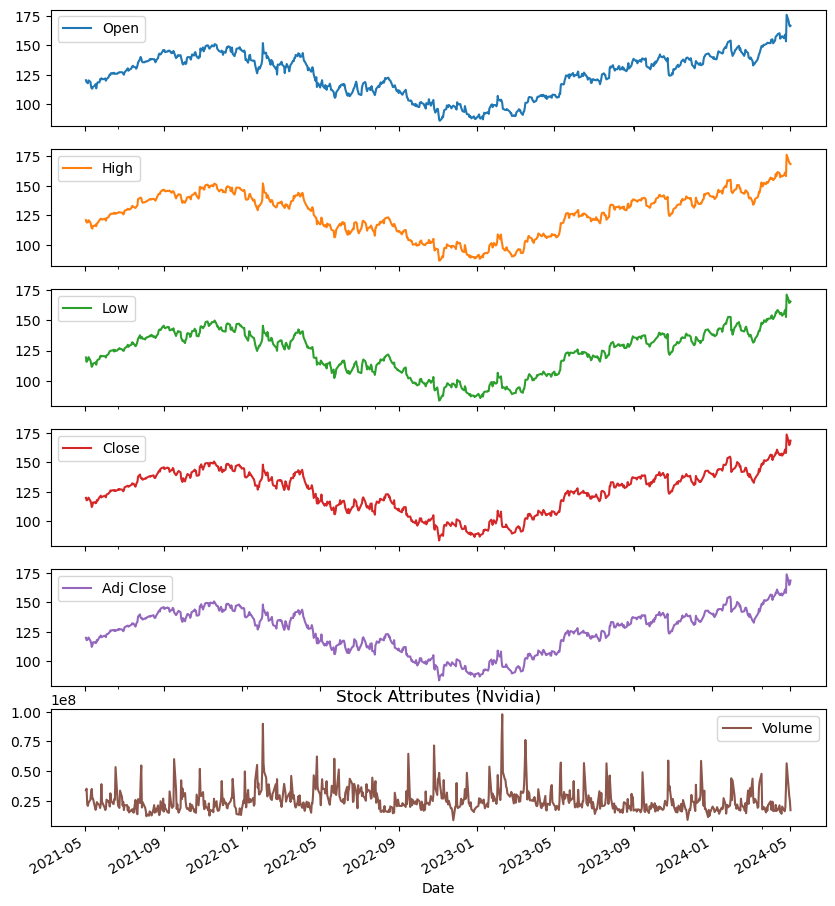

In [93]:
df_goog.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [94]:
fig = px.line(df_goog, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Judging from the stock price data, Google has be experiencing a rising trend since its lowest stock point in November 2022. The reason for the drop in stock price around that time could be attributed to the stock split that occurred in July 2022. As well as concerns about macroeconomic headwinds were what pushed both stocks to experience a two-year low in November 2022. In April 2022, Google released a disappointing first-quarter earnings report that lead to a drop in stock price before facing a further downward trend after the stock split.

After its drop, Google has started to recover but is now currently experiencing a court case regarding Search Engine Monopoly that may affect the stock price deeply depending on the result as the trial winds down.

In [95]:
fig = px.line(df_goog, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [96]:
# Google Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_goog.index, open=df_goog['Open'], high=df_goog['High'], low=df_goog['Low'], close=df_goog['Close'])])

fig.update_layout(title='Google Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

Text(0.5, 1.0, 'Google Moving Averages')

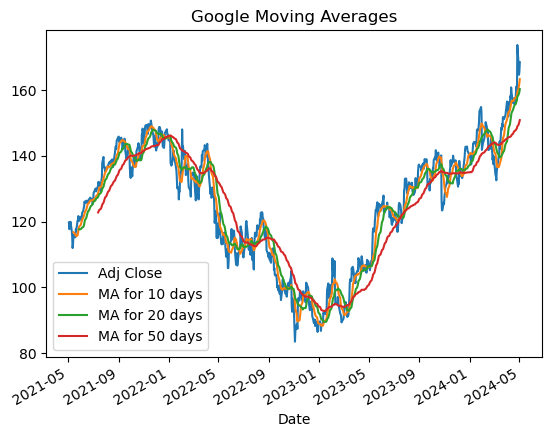

In [97]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_goog[column_name] = df_goog['Adj Close'].rolling(ma).mean()

df_goog[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Google Moving Averages")

Based on the graph above, the moving average for 10 and 20 days are following a downward trend. Based on the moving average for 10 days and 20 days, the price is experiencing worse than the expected average for the short term period. For the moving average of 50 days, the option of holding the stock is the best choice as the rises in stock price is doing better than the expected average aside from the sudden drops in stock price after earnings reports are released.

Text(0.5, 1.0, 'Google Daily Return')

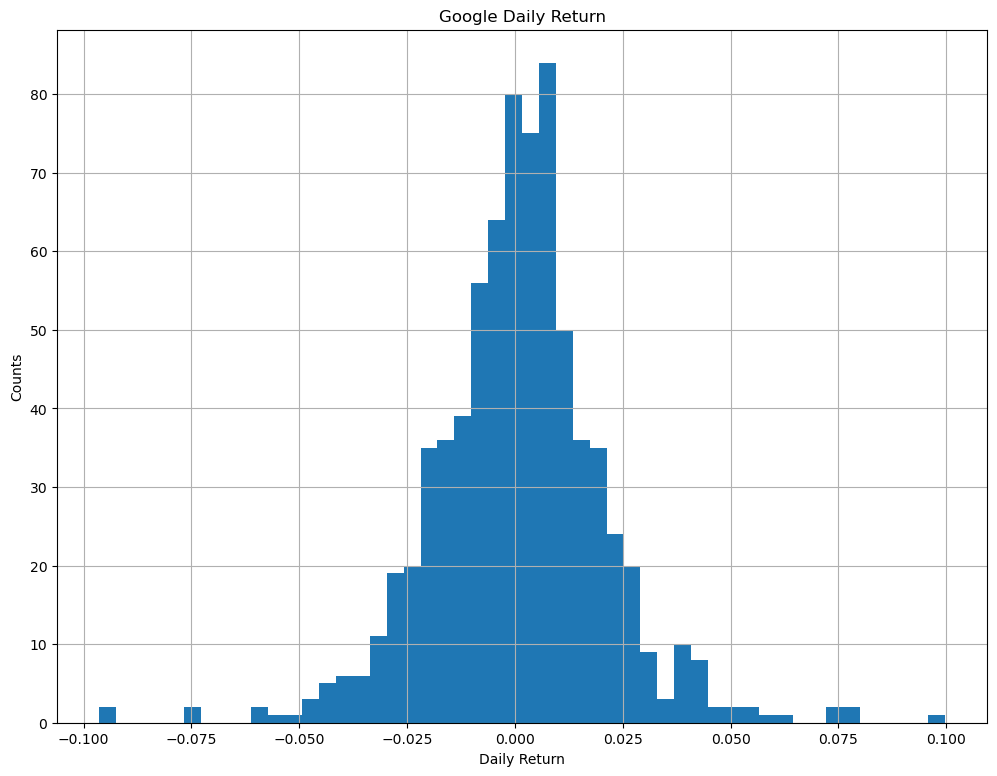

In [98]:
df_goog['Daily Return'] = df_goog['Adj Close'].pct_change()

plt.figure(figsize=(12,9))

df_goog['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Google Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis, forming a unimodal distribution. Increasing and decreasing approximately 5%.

#### Prediction Model for Google

In [99]:
start = datetime(end.year - 5, end.month, end.day)
df_goog = pdr.get_data_yahoo('GOOG', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [100]:
X = df_goog[['High', 'Low', 'Open']]  # Features
y = df_goog['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_goog.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

# creating a new dataset to analyze within 60 days
test_data = scaled_prices[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 2.8204e-04 - val_loss: 4.5310e-04
Epoch 2/100
30/30 [==============================] - 0s 16ms/step - loss: 2.7394e-04 - val_loss: 4.5957e-04
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 2.8133e-04 - val_loss: 4.9006e-04
Epoch 4/100
30/30 [==============================] - 0s 16ms/step - loss: 2.7967e-04 - val_loss: 4.5664e-04
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 2.7452e-04 - val_loss: 4.6114e-04
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 2.7832e-04 - val_loss: 4.5531e-04
Epoch 7/100
30/30 [==============================] - 0s 16ms/step - loss: 2.8130e-04 - val_loss: 4.7702e-04
Epoch 8/100
30/30 [==============================] - 0s 16ms/step - loss: 2.7463e-04 - val_loss: 4.5214e-04
Epoch 9/100
30/30 [==============================] - 0s 16ms/step - loss: 2.7907e-04 - val_loss: 4.5518e-04
Epoch 10/100
30/30 [========

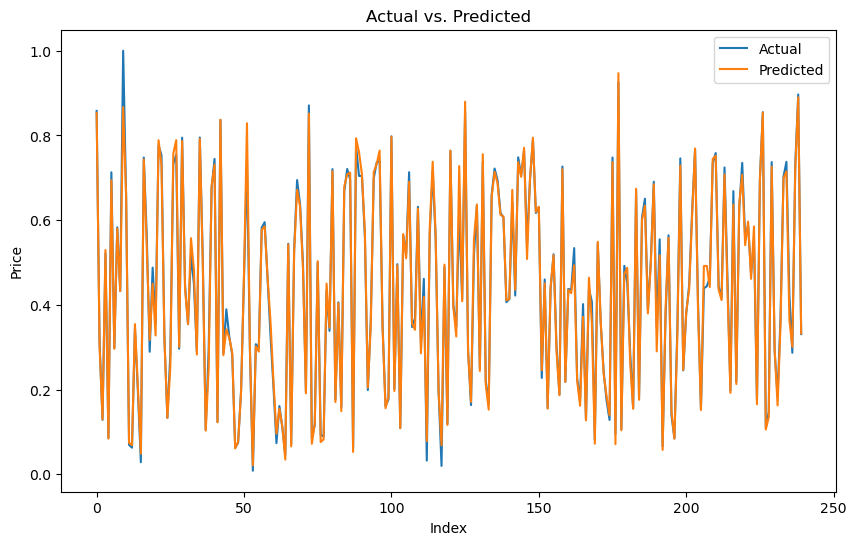

In [101]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

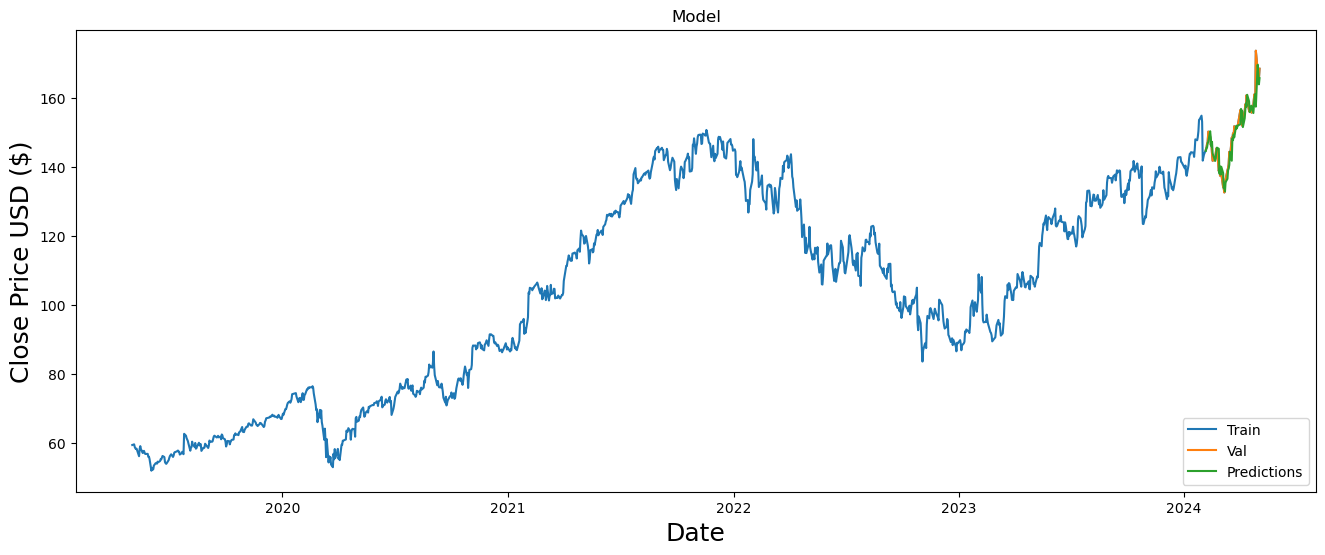

In [102]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_goog['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [103]:
valid

,Close,Predictions
Date,,
2024-02-05,144.929993,144.616287
2024-02-06,145.410004,145.483276
2024-02-07,146.679993,145.634232
2024-02-08,147.220001,146.838654
2024-02-09,150.220001,147.281403
...,...,...
2024-04-26,173.690002,157.463242
2024-04-29,167.899994,169.619614
2024-04-30,164.639999,167.219559


#### Prediction

In [104]:
future_days = 5

last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    # Predict the next day
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    # Store the predicted value
    predicted_values.append(predicted_decimal[0][0])
    
    # Shift the input data by one day for the next prediction
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value  # Replace the last value with the predicted value

print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 16ms/step
Predicted Decimal Values for the Next 5 Days: [168.99823, 169.06052, 168.91844, 168.917, 168.99046]


#### Conclusion

From my results, it would be a good choice to invest into Google as safe choice. Google holds a strong place in the stock market and tech industry and not having a too saturated stock market price to make it reasonable to invest into. A return in investment will be seen if the stock is held as a long-term investment to truly see its worth. 

For now, from predictions and relevant news regarding Google's antitrust case, Google's stock will possibly see a downward trend for a small point in the stock market, especially after the earnings report where some investors may sell their stocks depending on how they feel about the report. Google stock has been seen to rise in correlation with other companies such as Apple, Microsoft, and Nvidia. Helping Google rise in stock faster after any good news from other relevant companies.